# 1. Data

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train = datasets.Food101(root ='./data', split='train', download=True, transform=transform)

test = datasets.Food101(root ='./data', split='test', download=True, transform=transform)
train

100%|██████████| 4996278331/4996278331 [04:26<00:00, 18732624.59it/s]


Extracting ./data/food-101.tar.gz to ./data


Dataset Food101
    Number of datapoints: 75750
    Root location: ./data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
test

Dataset Food101
    Number of datapoints: 25250
    Root location: ./data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
classes = ['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'macaroni_and_cheese',
 'macarons',
 'miso_soup',
 'mussels',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pad_thai',
 'paella',
 'pancakes',
 'panna_cotta',
 'peking_duck',
 'pho',
 'pizza',
 'pork_chop',
 'poutine',
 'prime_rib',
 'pulled_pork_sandwich',
 'ramen',
 'ravioli',
 'red_velvet_cake',
 'risotto',
 'samosa',
 'sashimi',
 'scallops',
 'seaweed_salad',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'spaghetti_carbonara',
 'spring_rolls',
 'steak',
 'strawberry_shortcake',
 'sushi',
 'tacos',
 'takoyaki',
 'tiramisu',
 'tuna_tartare',
 'waffles']

In [6]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def plot_sample(index):

  images, labels = next(iter(train_loader))

  image = images[index]
  label = labels[index].item()

  # Convert tensor to numpy array
  image = np.transpose(image.numpy(), (1,2,0))

  plt.imshow(image)
  plt.title(f'Label: {classes[label]}')

  plt.show()

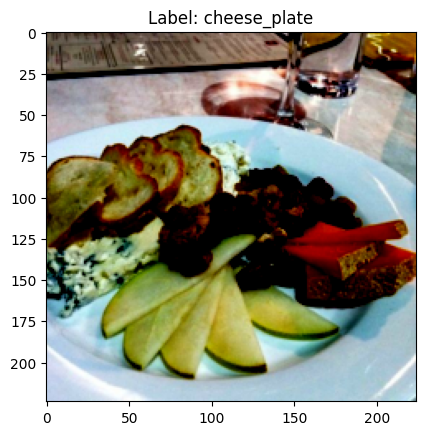

In [8]:
plot_sample(1)

# 2. Model

Change number of classes and freeze weights

In [9]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.base_model = models.efficientnet_b0()
        # for param in self.base_model.parameters():
        #     param.requires_grad = False

        # Replace the last layer with a new classifier
        # Adjust the in_features to match EfficientNet's last layer out_features
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, num_classes)
        )

        # No need to add another AvgPool, EfficientNet already includes it
        # No need for another classifier since we replaced the last layer

    def forward(self, x):
        # Forward pass through the modified base model
        x = self.base_model(x)
        return x

model = Classifier(101)


In [10]:
model.to(device)

Classifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [11]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

# 3. Traning

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

In [13]:
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0

    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()

        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    # print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [14]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0

    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)

    # print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

In [15]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

EPOCHS = 20

for epoch in range(EPOCHS):
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, val_loader)
    scheduler.step()
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.4f}, Val acc: {val_epoch_accuracy:.4f}')


Epoch 1, Loss: 0.2667, Train Acc: 4.9003, Val acc: 9.5050
Epoch 2, Loss: 0.2340, Train Acc: 11.9670, Val acc: 17.9960
Epoch 3, Loss: 0.2109, Train Acc: 18.6284, Val acc: 26.0238
Epoch 4, Loss: 0.1908, Train Acc: 25.0191, Val acc: 33.5960
Epoch 5, Loss: 0.1729, Train Acc: 31.1380, Val acc: 39.9327
Epoch 6, Loss: 0.1573, Train Acc: 36.8977, Val acc: 44.7960
Epoch 7, Loss: 0.1360, Train Acc: 44.2838, Val acc: 51.6594
Epoch 8, Loss: 0.1274, Train Acc: 47.4482, Val acc: 53.5485
Epoch 9, Loss: 0.1208, Train Acc: 49.8535, Val acc: 55.1485
Epoch 10, Loss: 0.1147, Train Acc: 52.1083, Val acc: 55.2792
Epoch 11, Loss: 0.1091, Train Acc: 54.2891, Val acc: 57.0733
Epoch 12, Loss: 0.1044, Train Acc: 55.9498, Val acc: 57.2990
Epoch 13, Loss: 0.0921, Train Acc: 60.6587, Val acc: 59.9683
Epoch 14, Loss: 0.0877, Train Acc: 62.1914, Val acc: 60.3564
Epoch 15, Loss: 0.0841, Train Acc: 63.3162, Val acc: 60.0871
Epoch 16, Loss: 0.0807, Train Acc: 64.6469, Val acc: 60.3842
Epoch 17, Loss: 0.0780, Train Acc: 

Learning curve

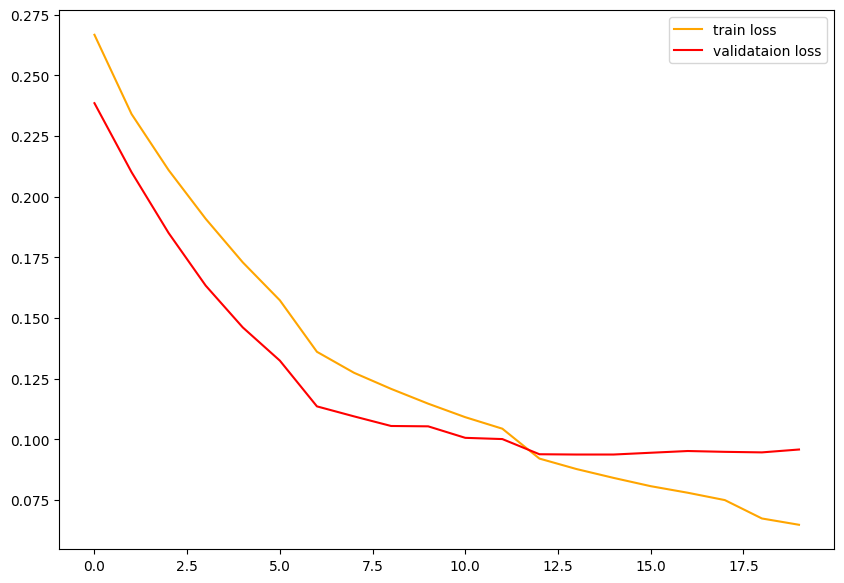

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

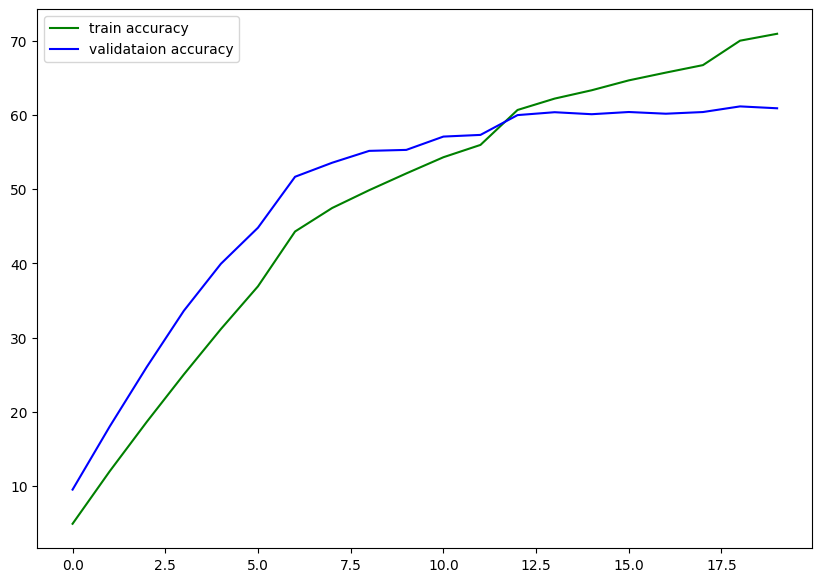

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

In [ ]:
correct = 0
total = 0

with torch.no_grad():

  for data in val_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f'Accuracy of model: {100 * correct / total:.2f} %')